In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os
from PIL import Image
import random
import warnings
warnings.filterwarnings('ignore')


2025-09-26 10:56:24.875626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758884185.084923      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758884185.144241      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1) # Veri Setinin Y√ºklenmesi ve ƒ∞ncelenmesi
Veri dizin yapƒ±sƒ±nƒ± kontrol etme:

Grafik ayarlarƒ±

In [2]:
plt.style.use('ggplot')
sns.set_palette("husl")

Veri dizin yapƒ±sƒ±nƒ± kontrol etme:

In [3]:
data_dir = '/kaggle/input/brain-tumor-mri-dataset'
training_dir = os.path.join(data_dir, 'Training')
testing_dir = os.path.join(data_dir, 'Testing')

In [4]:
class_names = os.listdir(training_dir)
print("Sƒ±nƒ±flar:", class_names)


Sƒ±nƒ±flar: ['pituitary', 'notumor', 'meningioma', 'glioma']


Veri k√ºmesinde yer alan sƒ±nƒ±flar;

pituitary :Hipofiz bezi t√ºm√∂rleri

glioma :Glial h√ºcrelerden kaynaklanan t√ºm√∂rler

meningioma :Beyin zarƒ± t√ºm√∂rleri

no_tumor :T√ºm√∂r i√ßermeyen MRI g√∂r√ºnt√ºleri

Her sƒ±nƒ±ftaki g√∂r√ºnt√º sayƒ±sƒ±nƒ± sayalƒ±m

In [5]:
train_counts = {}
test_counts = {}

for class_name in class_names:
    train_path = os.path.join(training_dir, class_name)
    test_path = os.path.join(testing_dir, class_name)
    
    train_counts[class_name] = len(os.listdir(train_path))
    test_counts[class_name] = len(os.listdir(test_path))

print("\nEƒüitim seti daƒüƒ±lƒ±mƒ±:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} g√∂r√ºnt√º")

print("\nTest seti daƒüƒ±lƒ±mƒ±:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count} g√∂r√ºnt√º")


Eƒüitim seti daƒüƒ±lƒ±mƒ±:
pituitary: 1457 g√∂r√ºnt√º
notumor: 1595 g√∂r√ºnt√º
meningioma: 1339 g√∂r√ºnt√º
glioma: 1321 g√∂r√ºnt√º

Test seti daƒüƒ±lƒ±mƒ±:
pituitary: 300 g√∂r√ºnt√º
notumor: 405 g√∂r√ºnt√º
meningioma: 306 g√∂r√ºnt√º
glioma: 300 g√∂r√ºnt√º


Her sƒ±nƒ±ftan √∂rnek g√∂r√ºnt√ºleri g√∂sterme

Resim dosyasƒ± yapƒ±sƒ±nƒ± kontrol edelim

In [6]:

for class_name in class_names:
    class_path = os.path.join(training_dir, class_name)
    if os.path.exists(class_path):
        files = os.listdir(class_path)
        img_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'))]
        print(f" {class_name}: {len(img_files)} resim dosyasƒ±")
    else:
        print(f" {class_name} klas√∂r√º bulunamadƒ±: {class_path}")

 pituitary: 1457 resim dosyasƒ±
 notumor: 1595 resim dosyasƒ±
 meningioma: 1339 resim dosyasƒ±
 glioma: 1321 resim dosyasƒ±


Her Sƒ±nƒ±ftan Bir √ñrnek G√∂r√ºnt√º G√∂sterimi

 pituitary: Tr-pi_0532.jpg ba≈üarƒ±yla y√ºklendi
 notumor: Tr-no_0482.jpg ba≈üarƒ±yla y√ºklendi
 meningioma: Tr-me_0529.jpg ba≈üarƒ±yla y√ºklendi
 glioma: Tr-gl_0954.jpg ba≈üarƒ±yla y√ºklendi


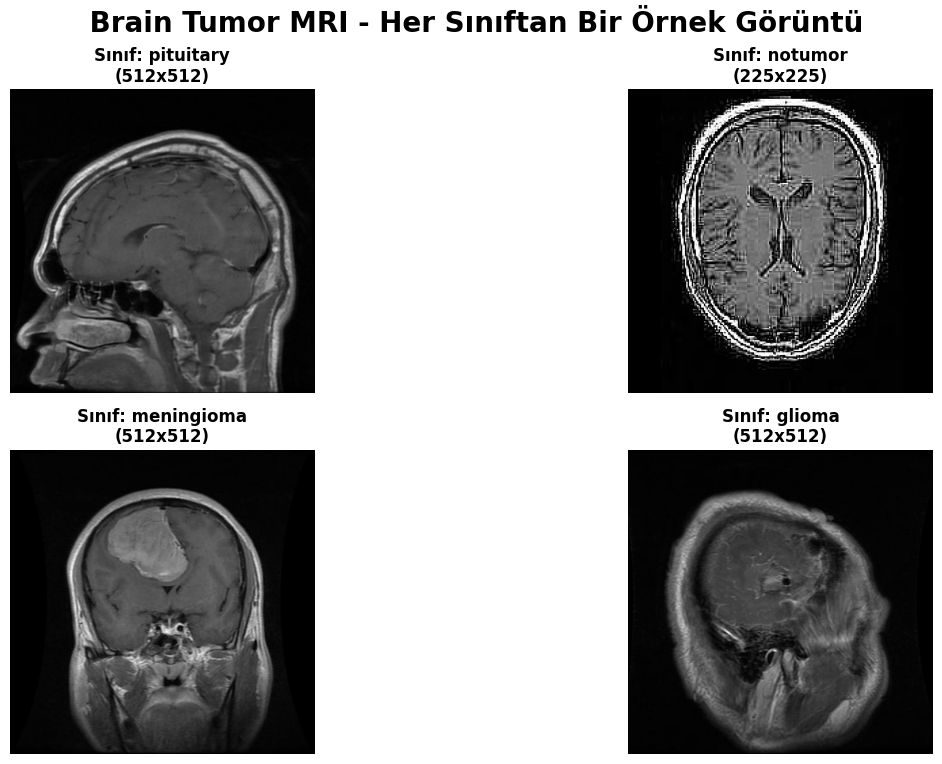

In [7]:

plt.figure(figsize=(15, 8))

for i, class_name in enumerate(class_names):
    try:
        # Sƒ±nƒ±f yolunu olu≈ütur
        class_path = os.path.join(training_dir, class_name)
        
        # Klas√∂r√ºn var olduƒüundan emin ol
        if not os.path.exists(class_path):
            print(f" Klas√∂r bulunamadƒ±: {class_path}")
            continue
            
        # Klas√∂rdeki resim dosyalarƒ±nƒ± al
        img_files = [f for f in os.listdir(class_path) 
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
        
        if not img_files:
            print(f"{class_name} klas√∂r√ºnde resim dosyasƒ± bulunamadƒ±")
            # Bo≈ü subplot g√∂ster
            plt.subplot(2, 2, i+1)
            plt.text(0.5, 0.5, 'Resim\nBulunamadƒ±', 
                    ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
            plt.title(f'Sƒ±nƒ±f: {class_name}', fontweight='bold')
            plt.axis('off')
            continue
        
        # ƒ∞lk resmi se√ß (veya rastgele bir resim se√ßmek i√ßin: random.choice(img_files))
        sample_file = img_files[0]
        sample_path = os.path.join(class_path, sample_file)
        
        # G√∂r√ºnt√ºy√º y√ºkle
        img = Image.open(sample_path)
        
        # Subplot olu≈ütur
        plt.subplot(2, 2, i+1)  # 2x2 grid, 4 sƒ±nƒ±f i√ßin ideal
        
        # G√∂r√ºnt√ºy√º g√∂ster (MRI g√∂r√ºnt√ºleri i√ßin gri tonlamalƒ±)
        if img.mode == 'L':  # Gri tonlamalƒ±
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
            
        plt.title(f'Sƒ±nƒ±f: {class_name}\n({img.size[0]}x{img.size[1]})', 
                 fontweight='bold', fontsize=12)
        plt.axis('off')
        
        print(f" {class_name}: {sample_file} ba≈üarƒ±yla y√ºklendi")
        
    except Exception as e:
        print(f"{class_name} y√ºklenirken hata: {str(e)}")
        # Hata durumunda bo≈ü subplot
        plt.subplot(2, 2, i+1)
        plt.text(0.5, 0.5, 'Y√ºkleme\nHatasi', 
                ha='center', va='center', fontsize=12, color='red', 
                transform=plt.gca().transAxes)
        plt.title(f'Sƒ±nƒ±f: {class_name}', fontweight='bold')
        plt.axis('off')

plt.suptitle(' Brain Tumor MRI - Her Sƒ±nƒ±ftan Bir √ñrnek G√∂r√ºnt√º', 
             fontsize=20, fontweight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()



her sƒ±nƒ±ftan iki √∂rnek g√∂r√ºnt√º

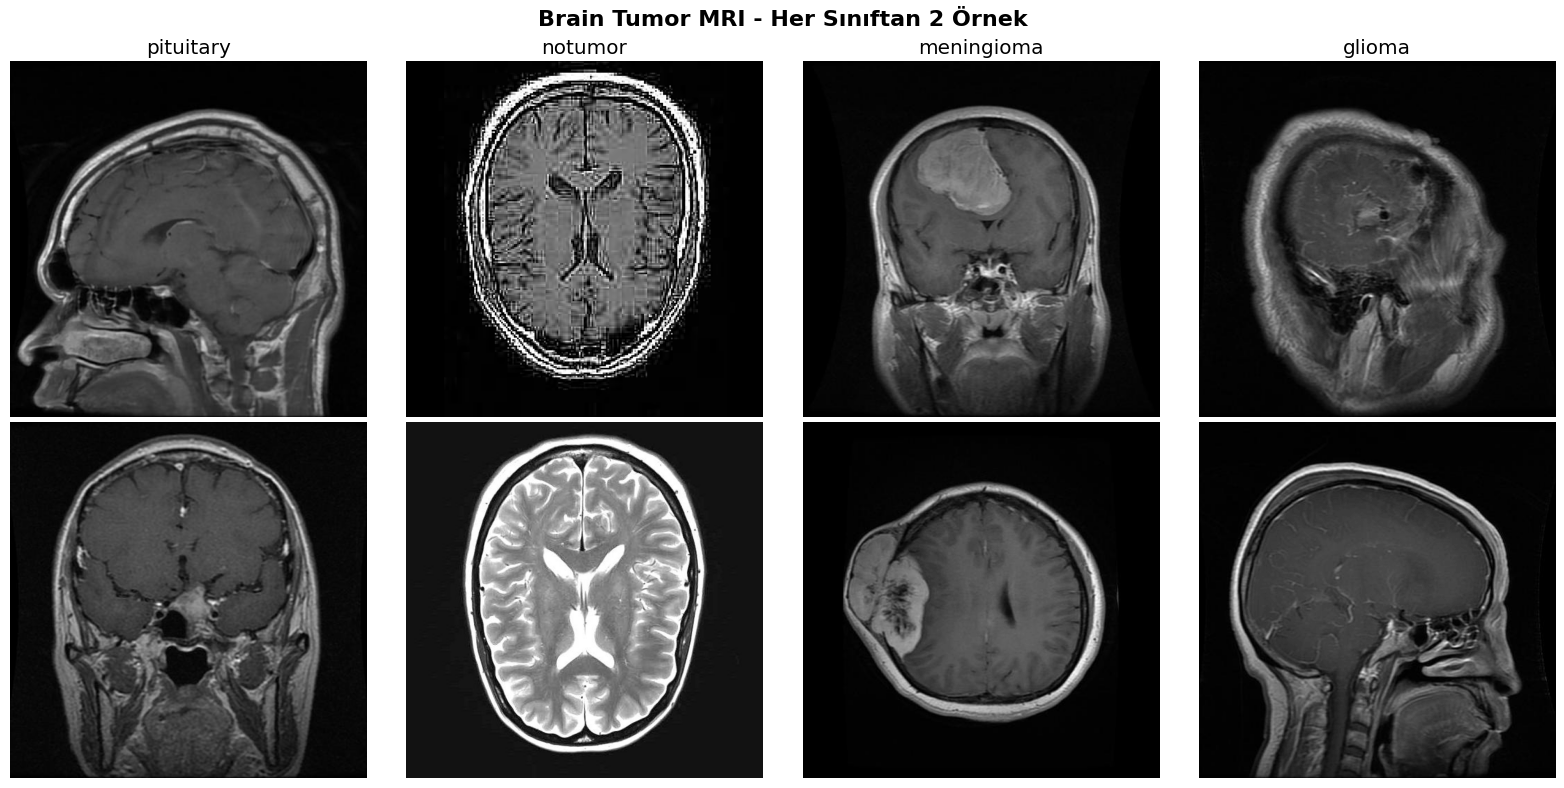

Hiperparametre optimizasyonu hazƒ±r


In [8]:
# 

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(training_dir, class_name)
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:2]
    
    for j, img_file in enumerate(img_files):
        img_path = os.path.join(class_path, img_file)
        img = plt.imread(img_path)
        
        axes[j, i].imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        axes[j, i].set_title(f'{class_name}' if j == 0 else '')
        axes[j, i].axis('off')

plt.suptitle('Brain Tumor MRI - Her Sƒ±nƒ±ftan 2 √ñrnek', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ## 10. ‚öôÔ∏è Hiperparametre Optimizasyonu

import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    
    for i in range(hp.Int('conv_layers', 2, 4)):
        model.add(Conv2D(hp.Int(f'filters_{i}', 32, 128, step=32), (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5)))
    
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', 128, 512, step=128), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    
    model.compile(
        optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Hiperparametre optimizasyonu hazƒ±r")

Bir sƒ±nƒ±fta ka√ß adet g√∂r√ºnt√º olduƒüunu g√∂relim:

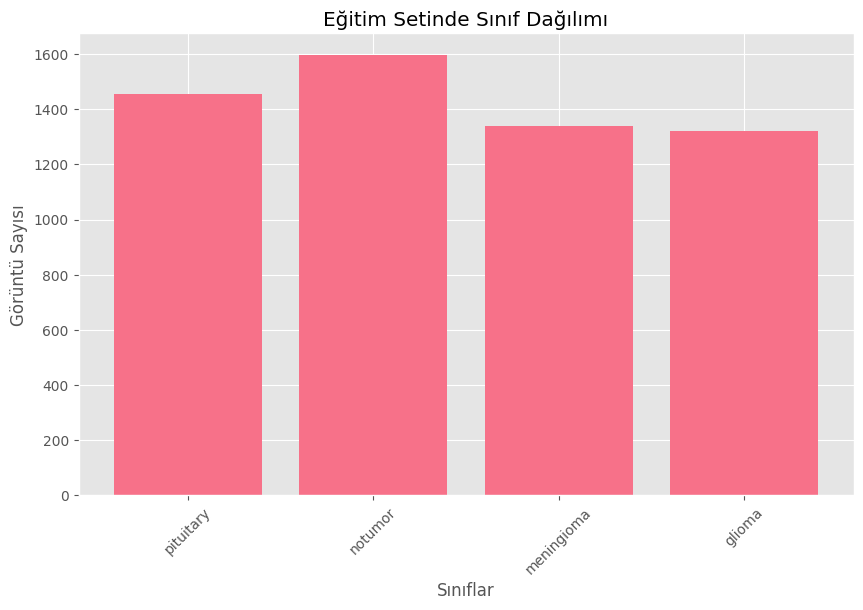

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(train_counts.keys(), train_counts.values())
plt.title('Eƒüitim Setinde Sƒ±nƒ±f Daƒüƒ±lƒ±mƒ±')
plt.xlabel('Sƒ±nƒ±flar')
plt.ylabel('G√∂r√ºnt√º Sayƒ±sƒ±')
plt.xticks(rotation=45)
plt.show()


G√∂r√ºnt√º boyutlarƒ±nƒ± belirliyoruz (VGG16 i√ßin 224x224 alƒ±yoruz)

In [10]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

Eƒüitim verisi i√ßin augmentation uyguluyoruz

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # Validation i√ßin %20 ayƒ±r
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


Eƒüitim verisi i√ßin augmentation uyguluyoruz

Eƒüitim verisi generator'ƒ±

In [13]:
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Eƒüitim √∂rnekleri: {train_generator.samples}")
print(f"Validation √∂rnekleri: {validation_generator.samples}")
print(f"Test √∂rnekleri: {test_generator.samples}")

Found 1311 images belonging to 4 classes.
Eƒüitim √∂rnekleri: 4571
Validation √∂rnekleri: 1141
Test √∂rnekleri: 1311


Validation verisi generator'ƒ±

In [14]:
validation_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',                   # Validation i√ßin olan kƒ±smƒ± al
    shuffle=True,
    seed=42
)

Found 1141 images belonging to 4 classes.


# CNN MODELƒ∞ OLU≈ûTURMA

In [15]:
def create_cnn_model():
    model = Sequential([
        # ƒ∞lk Conv Block
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # ƒ∞kinci Conv Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
       
        # √ú√ß√ºnc√º Conv Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # D√∂rd√ºnc√º Conv Block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

         # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')  # 4 sƒ±nƒ±f
    ])
    
    return model



Modeli olu≈üturma ve √∂zetini g√∂sterme

In [16]:
cnn_model = create_cnn_model()
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("CNN Model √ñzeti:")
cnn_model.summary()


I0000 00:00:1758884207.788271      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758884207.789001      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


CNN Model √ñzeti:


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 222, 222, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 222, 222, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 111, 111, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 111, 111, 32)   ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 109, 109, 64)   ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 109, 109, 64)   ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)  ‚îÇ (None, 54, 54, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 54, 54, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 52, 52, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 52, 52, 128)    ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)  ‚îÇ (None, 26, 26, 128)   

 Total params: 19,399,620 (74.00 MB)

 Trainable params: 19,397,636 (74.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

# Model Eƒüitimi

In [17]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


Model Eƒüitimi

In [18]:
history = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50


I0000 00:00:1758884217.877908      94 service.cc:148] XLA service 0x7a330801a490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758884217.878914      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758884217.878939      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758884218.691907      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 87ms/step - accuracy: 0.2500 - loss: 2.7903 

I0000 00:00:1758884229.049380      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 124s 744ms/step - accuracy: 0.5499 - loss: 1.2633 - val_accuracy: 0.2550 - val_loss: 9.5442 - learning_rate: 0.0010
Epoch 2/50
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 75s 527ms/step - accuracy: 0.6397 - loss: 0.9228 - val_accuracy: 0.2603 - val_loss: 3.5375 - learning_rate: 0.0010
Epoch 3/50
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 77s 537ms/step - accuracy: 0.6761 - loss: 0.8215 - val_accuracy: 0.3786 - val_loss: 2.9801 - learning_rate: 0.0010
Epoch 4/50
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 76s 530ms/step - accuracy: 0.7349 - loss: 0.7062 - val_accuracy: 0.2883 - val_loss: 5.7340 - learning_rate: 0.0010
Epoch 5/50
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 74s 519ms/step - accuracy: 0.7497 - loss: 0.6275 - val_accuracy: 0.2901 - val_loss: 10.6372 - learning_rate: 0.0010
Epoch 6/50
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

# Model Deƒüerlendirme

Loss ve Accuracy grafikleri

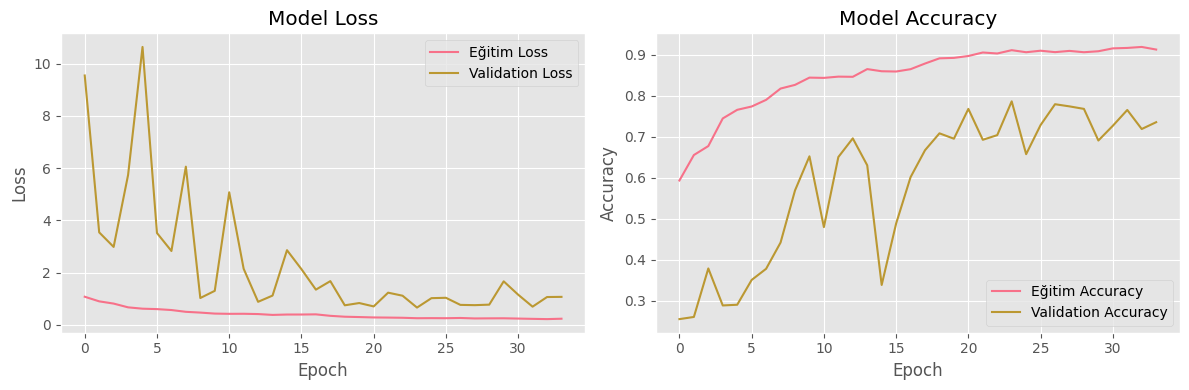

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eƒüitim Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eƒüitim Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Test seti √ºzerinde deƒüerlendirme

In [20]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

41/41 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 231ms/step - accuracy: 0.6494 - loss: 0.9953

Test Accuracy: 0.7674
Test Loss: 0.6681


Tahminler

In [21]:
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

41/41 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 99ms/step


Confusion Matrix

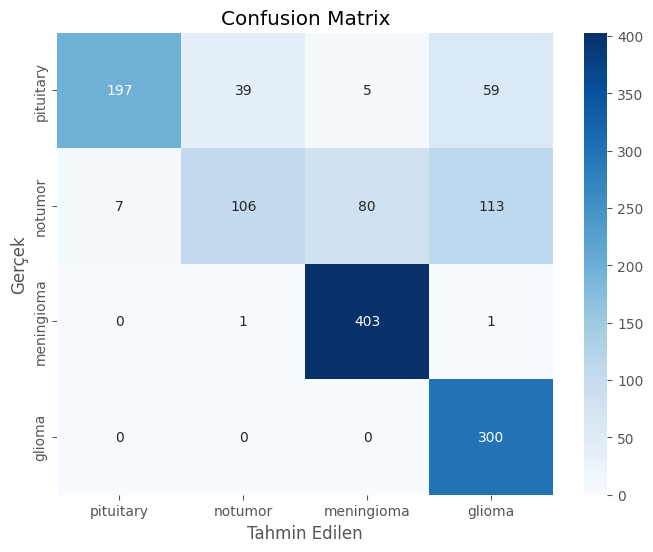

In [22]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Ger√ßek')
plt.show()

Classification Report

In [23]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

   pituitary       0.97      0.66      0.78       300
     notumor       0.73      0.35      0.47       306
  meningioma       0.83      1.00      0.90       405
      glioma       0.63      1.00      0.78       300

    accuracy                           0.77      1311
   macro avg       0.79      0.75      0.73      1311
weighted avg       0.79      0.77      0.74      1311



Transfer Learning (VGG16)

58889256/58889256 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step
VGG16 Model √ñzeti:


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ vgg16 (Functional)              ‚îÇ (None, 7, 7, 512)      ‚îÇ    14,714,688 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 512)            ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ (None, 256)            ‚îÇ       131,328 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_5           ‚îÇ (None, 256)            ‚îÇ         1,024 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_6 (Dropout)             ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                 ‚îÇ (None, 4)              ‚îÇ         1,028 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 14,848,068 (56.64 MB)

 Trainable params: 132,868 (519.02 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

 VGG16 modeli eƒüitiliyor (Bonus b√∂l√ºm)...
Epoch 1/15
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 123s 729ms/step - accuracy: 0.4495 - loss: 1.3569 - val_accuracy: 0.6004 - val_loss: 1.1728 - learning_rate: 1.0000e-04
Epoch 2/15
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 563ms/step - accuracy: 0.6975 - loss: 0.7701 - val_accuracy: 0.6380 - val_loss: 0.9664 - learning_rate: 1.0000e-04
Epoch 3/15
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79s 555ms/step - accuracy: 0.7703 - loss: 0.6085 - val_accuracy: 0.7046 - val_loss: 0.7978 - learning_rate: 1.0000e-04
Epoch 4/15
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79s 553ms/step - accuracy: 0.7860 - loss: 0.5734 - val_accuracy: 0.6573 - val_loss: 0.9115 - learning_rate: 1.0000e-04
Epoch 5/15
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 80s 556ms/step - accuracy: 0.7946 - loss: 0.5409 - val_accuracy: 0.7143 - val_

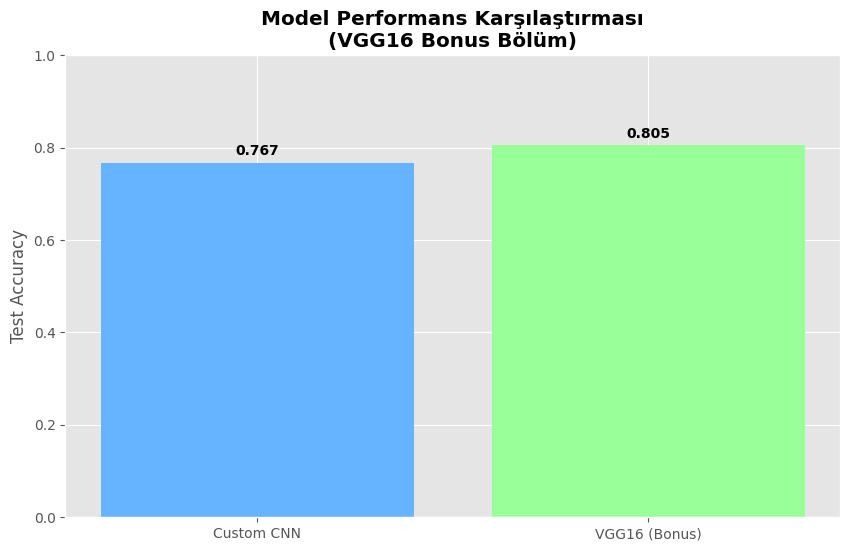

In [24]:
# Transfer Learning (VGG16)

def create_vgg16_model():
    
    
    # ImageNet'te √∂nceden eƒüitilmi≈ü VGG16 modelini y√ºkle
    base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # √ñnceden eƒüitilmi≈ü katmanlarƒ± dondur
    base_model.trainable = False
    
    # Yeni modeli olu≈ütur - D√úZG√úN Gƒ∞RENTƒ∞ ƒ∞LE
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    
    return model

# VGG16 modelini olu≈ütur
vgg_model = create_vgg16_model()
vgg_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("VGG16 Model √ñzeti:")
vgg_model.summary()

# VGG16 modelini eƒüit
print(" VGG16 modeli eƒüitiliyor (Bonus b√∂l√ºm)...")
vgg_history = vgg_model.fit(
    train_generator,
    epochs=15,  # Daha az epoch yeterli
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# VGG16 deƒüerlendirme
vgg_test_loss, vgg_test_accuracy = vgg_model.evaluate(test_generator)
print(f"\n VGG16 Test Accuracy: {vgg_test_accuracy:.4f}")
print(f" VGG16 Test Loss: {vgg_test_loss:.4f}")

# Model kar≈üƒ±la≈ütƒ±rmasƒ±
models_comparison = {
    'Custom CNN': test_accuracy,
    'VGG16 (Bonus)': vgg_test_accuracy
}

plt.figure(figsize=(10, 6))
bars = plt.bar(models_comparison.keys(), models_comparison.values(), 
               color=['#66b3ff', '#99ff99'])
plt.title('Model Performans Kar≈üƒ±la≈ütƒ±rmasƒ±\n(VGG16 Bonus B√∂l√ºm)', fontweight='bold')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)

# √áubuklarƒ±n √ºzerine deƒüerleri yaz
for bar, accuracy in zip(bars, models_comparison.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{accuracy:.3f}', ha='center', va='bottom', fontweight='bold')

plt.show()

In [25]:
def grad_cam(model, img_array, layer_name):
    # Grad-CAM implementasyonu buraya eklenecek
    pass


Hƒ∞PERPARAMETRE OPTƒ∞Mƒ∞ZASYONU

In [26]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(), MaxPooling2D(2,2), Dropout(0.25),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(), MaxPooling2D(2,2), Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'), Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
history = model.fit(
    train_generator,
    epochs=2,  # Hƒ±zlƒ± test
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/2
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 86s 551ms/step - accuracy: 0.3807 - loss: 23.8839 - val_accuracy: 0.2314 - val_loss: 119.1591
Epoch 2/2
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 74s 521ms/step - accuracy: 0.3627 - loss: 1.3013 - val_accuracy: 0.2358 - val_loss: 139.6632


In [28]:
model.save('brain_tumor_cnn.h5')

vgg_model.save('brain_tumor_vgg.h5')
print("Model kaydedildi!")

Model kaydedildi!


Sonu√ß kar≈üƒ±la≈ütƒ±rma

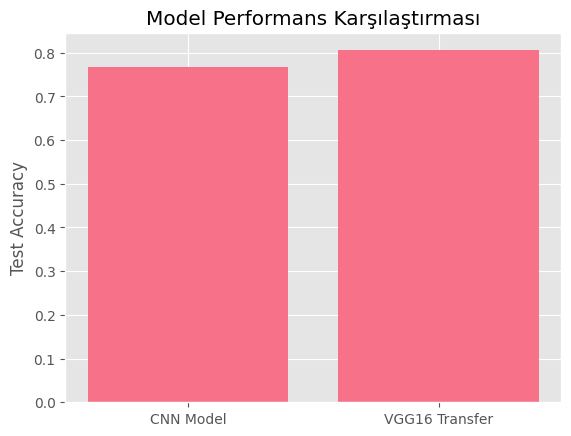

üéâ PROJE TAMAMLANDI!
üìä Sonu√ßlar:
   - CNN Model Test Accuracy: 0.7674
   - VGG16 Transfer Learning: 0.8055


In [29]:
models_comparison = {'CNN Model': test_accuracy, 'VGG16 Transfer': vgg_test_accuracy}
plt.bar(models_comparison.keys(), models_comparison.values())
plt.title('Model Performans Kar≈üƒ±la≈ütƒ±rmasƒ±')
plt.ylabel('Test Accuracy')
plt.show()

print("üéâ PROJE TAMAMLANDI!")
print("üìä Sonu√ßlar:")
print(f"   - CNN Model Test Accuracy: {test_accuracy:.4f}")
print(f"   - VGG16 Transfer Learning: {vgg_test_accuracy:.4f}")